In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
import pytorch_lightning as pl
import torch
from torch import nn
import torchvision.models as models
from pytorch_lightning.metrics import MetricCollection, Accuracy, Precision, Recall, ConfusionMatrix, PrecisionRecallCurve
from pytorch_lightning.callbacks import ModelCheckpoint


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
class FullySupervisedModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Sequential()
        
#         for name, param in self.image_model.named_parameters():
#             if "layer4.1" not in name:
#                 print(name)
#                 param.requires_grad = False
        
        self.predictor = nn.Sequential(nn.Linear(512, 256),
                                       nn.ReLU(),
                                       nn.Linear(256,1))

        
        self.train_metrics = MetricCollection({
                                                "tr/acc": Accuracy(threshold = 0.5),
                                                "tr/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "tr/recall":Recall(is_multiclass = False, threshold = 0.5),
                                                
        })
        self.valid_metrics = MetricCollection({
                                                "val/acc": Accuracy(threshold = 0.5),
                                                "val/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "val/recall":Recall(is_multiclass = False, threshold = 0.5)
        })
        self.test_metrics = MetricCollection({
                                                "test/acc": Accuracy(threshold = 0.5),
                                                "test/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "test/recall":Recall(is_multiclass = False, threshold = 0.5)
        })
        

        self.confmat = ConfusionMatrix(num_classes=2, threshold = 0.5)
        self.prc = PrecisionRecallCurve(num_classes = 1)
    
    def loss(self,x,y, weight = None):
        if weight is None:
            return nn.functional.binary_cross_entropy_with_logits(x.squeeze(),y.squeeze())
        else:
            return nn.functional.binary_cross_entropy_with_logits(x.squeeze(),y.squeeze(), weight = weight.squeeze())
    
    def forward(self,unknown_image):
        
        encoded_unknown_image = self.image_model(unknown_image)
        prediction = self.predictor(encoded_unknown_image)
        return prediction

    def training_step(self, batch, batch_idx):
        prediction = self.forward(batch['unknown image'])

        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("tr/loss", reconstruction_loss)
        
        self.train_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.train_metrics, on_step=True, on_epoch=True)
        return reconstruction_loss

    def validation_step(self, batch, batch_idx):
        prediction = self.forward(batch['unknown image'])
        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("val/loss", reconstruction_loss)
        
        self.valid_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.valid_metrics, on_step=False, on_epoch=True)
        
        return reconstruction_loss
    
    def test_step(self, batch, batch_idx):
        
        prediction = self.forward(batch['unknown image'])
        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("test/loss", reconstruction_loss)
        
        self.test_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)
        self.confmat.update(torch.sigmoid(prediction), batch['label'].squeeze().long())
        #print(torch.sigmoid(prediction).shape)
        self.prc.update(torch.sigmoid(prediction).squeeze(), batch['label'].squeeze().long())
        return reconstruction_loss
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.000002)

In [5]:
from datamodule import ZeroShotDataModule
dm = ZeroShotDataModule(batch_size = 64, 
                        test_plants = 'all', 
                        train_plants = 'all')
dm.setup()

plants in this dataset: ['Apple', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Peach', 'Pepper,_bell', 'Potato', 'Strawberry', 'Tomato']
Apple, Black_rot: 434
Apple, healthy: 1151
Apple, Apple_scab: 441
Apple, Cedar_apple_rust: 192
Cherry_(including_sour), healthy: 597
Cherry_(including_sour), Powdery_mildew: 736
Corn_(maize), Northern_Leaf_Blight: 689
Corn_(maize), healthy: 813
Corn_(maize), Common_rust_: 834
Corn_(maize), Cercospora_leaf_spot Gray_leaf_spot: 359
Grape, Esca_(Black_Measles): 968
Grape, Black_rot: 826
Grape, healthy: 296
Grape, Leaf_blight_(Isariopsis_Leaf_Spot): 753
Peach, healthy: 251
Peach, Bacterial_spot: 1607
Pepper,_bell, healthy: 1033
Pepper,_bell, Bacterial_spot: 697
Potato, healthy: 106
Potato, Late_blight: 700
Potato, Early_blight: 700
Strawberry, healthy: 319
Strawberry, Leaf_scorch: 776
Tomato, Septoria_leaf_spot: 1239
Tomato, Leaf_Mold: 666
Tomato, healthy: 1113
Tomato, Spider_mites Two-spotted_spider_mite: 1173
Tomato, Late_blight: 1336
Tomato, Ba

In [6]:
model = FullySupervisedModel()
checkpoint_callback = ModelCheckpoint(monitor='val/loss')
trainer = pl.Trainer(gpus = 1, max_epochs = 100, log_every_n_steps=1, fast_dev_run = False, callbacks = checkpoint_callback)
trainer.fit(model, dm)

/home/dennis/klab-localization/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | image_model   | ResNet               | 11.2 M
1 | predictor     | Sequential           | 131 K 
2 | train_metrics | MetricCollection     | 0     
3 | valid_metrics | MetricCollection     | 0     
4 | test_metrics  | MetricCollection     | 0     
5 | confmat       | ConfusionMatrix      | 0     
6 | prc           | PrecisionRecallCurve | 0     
-------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
4

1

In [8]:
model = FullySupervisedModel.load_from_checkpoint(checkpoint_path = checkpoint_callback.best_model_path)

/home/dennis/klab-localization/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [9]:
print(checkpoint_callback.best_model_path)

/home/dennis/agriculture/lightning_logs/version_69/checkpoints/epoch=73-step=32411.ckpt


In [10]:
res = trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


/home/dennis/klab-localization/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9803758263587952,
 'test/loss': 0.0006062488537281752,
 'test/precision': 0.9220183491706848,
 'test/recall': 0.9869067072868347}
--------------------------------------------------------------------------------


tensor([[4689.,  102.],
        [  16., 1206.]], device='cuda:0')


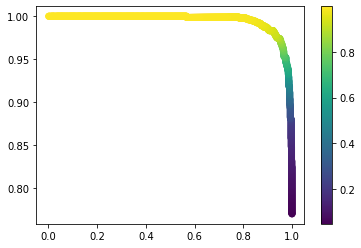

In [11]:
print(model.confmat.compute())
precision, recall, thresholds = model.prc.compute()
import matplotlib.pyplot as plt
#print(thresholds)
plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze())
plt.colorbar()

In [20]:
metrics = {}
for (plant_name, dl) in dm.test_indiv_plants_dataloaders().items():
    model.confmat.reset()
    model.prc.reset()
    print(plant_name)
    res = trainer.test(model, test_dataloaders= dl)
    cm = model.confmat.compute().T
    accuracy = ((cm[0,0] + cm[1,1])/torch.sum(cm)).cpu().detach().numpy()
    #print(accuracy)
    precision = (cm[1,1]/(cm[1,0] + cm[1,1])).cpu().detach().numpy()
    #print(precision)
    recall = (cm[1,1]/(cm[0,1] + cm[1,1])).cpu().detach().numpy()
    #print(recall)
    metrics[plant_name] = {"accuracy": accuracy, "precision": precision, "recall": recall}
#     precision, recall, thresholds = model.prc.compute()
#     plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze())
#     plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Apple


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9958158731460571,
 'test/loss': 0.012027748860418797,
 'test/precision': 0.9919678568840027,
 'test/recall': 1.0}
--------------------------------------------------------------------------------
Cherry_(including_sour)


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close(






--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 1.0,
 'test/loss': 0.002529504708945751,
 'test/precision': 1.0,
 'test/recall': 1.0}
--------------------------------------------------------------------------------
Corn_(maize)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9965457916259766,
 'test/loss': 0.004295057151466608,
 'test/precision': 0.9942857027053833,
 'test/recall': 0.9942857027053833}
--------------------------------------------------------------------------------
Grape


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 1.0,
 'test/loss': 0.0002188549842685461,
 'test/precision': 1.0,
 'test/recall': 1.0}
--------------------------------------------------------------------------------
Peach


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9725000262260437,
 'test/loss': 0.00914457906037569,
 'test/precision': 0.8333333134651184,
 'test/recall': 1.0}
--------------------------------------------------------------------------------
Pepper,_bell


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9892473220825195,
 'test/loss': 0.014709747396409512,
 'test/precision': 0.9909909963607788,
 'test/recall': 0.9909909963607788}
--------------------------------------------------------------------------------
Potato


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.99071204662323,
 'test/loss': 0.007043837103992701,
 'test/precision': 0.9166666865348816,
 'test/recall': 0.95652174949646}
--------------------------------------------------------------------------------
Strawberry


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 1.0,
 'test/loss': 0.001603361451998353,
 'test/precision': 1.0,
 'test/recall': 1.0}
--------------------------------------------------------------------------------
Tomato



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9648093581199646,
 'test/loss': 0.017711373046040535,
 'test/precision': 0.729903519153595,
 'test/recall': 0.9497907757759094}
--------------------------------------------------------------------------------


In [21]:
print(metrics)

{'Apple': {'accuracy': array(0.9958159, dtype=float32), 'precision': array(0.99196786, dtype=float32), 'recall': array(1., dtype=float32)}, 'Cherry_(including_sour)': {'accuracy': array(1., dtype=float32), 'precision': array(1., dtype=float32), 'recall': array(1., dtype=float32)}, 'Corn_(maize)': {'accuracy': array(0.9965458, dtype=float32), 'precision': array(0.9942857, dtype=float32), 'recall': array(0.9942857, dtype=float32)}, 'Grape': {'accuracy': array(1., dtype=float32), 'precision': array(1., dtype=float32), 'recall': array(1., dtype=float32)}, 'Peach': {'accuracy': array(0.9725, dtype=float32), 'precision': array(0.8333333, dtype=float32), 'recall': array(1., dtype=float32)}, 'Pepper,_bell': {'accuracy': array(0.9892473, dtype=float32), 'precision': array(0.990991, dtype=float32), 'recall': array(0.990991, dtype=float32)}, 'Potato': {'accuracy': array(0.99071205, dtype=float32), 'precision': array(0.9166667, dtype=float32), 'recall': array(0.95652175, dtype=float32)}, 'Strawber

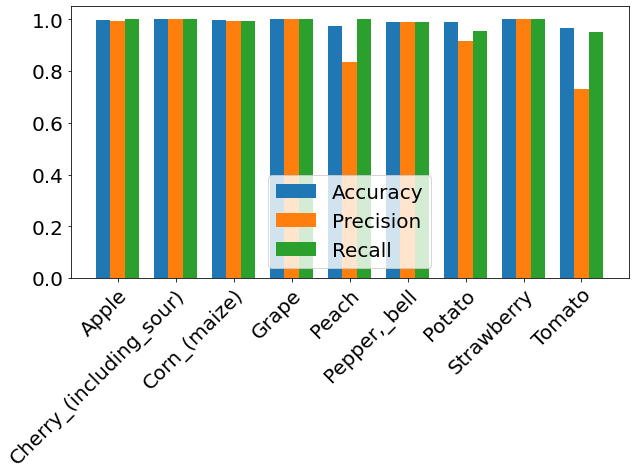

In [54]:
import numpy as np
width = 0.25
plt.figure(figsize=(10,5))
plt.bar(np.array((range(len(metrics.keys())))) - width, [a['accuracy'] for a in metrics.values()], width, label="Accuracy")
plt.bar(np.array(range(len(metrics.keys()))), [a['precision'] for a in metrics.values()], width, label="Precision")
plt.bar(np.array(range(len(metrics.keys())))+width, [a['recall'] for a in metrics.values()], width, label="Recall")
plt.gca().set_xticks(np.array((range(len(metrics.keys())))))
plt.gca().set_xticklabels([key for key,_ in dm.test_indiv_plants_dataloaders().items()], fontdict = {"fontsize":20})
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(fontsize=20)
plt.legend(loc ='lower center', fontsize = 20)

In [55]:
np.save("fully_supervised_results.npy", metrics)